## Data transforming

#### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns
palette = sns.color_palette("muted")

import warnings
warnings.filterwarnings('ignore')

#### Reading dataframe

In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.shape

(891, 12)

We see that our dataframe has 891 samples with 12 features

In [4]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


#### Duplicates

In [6]:
sum(df.duplicated())

0

There is no duplicates in dataframe

#### Dropping unnecessary features
It can be seen that `PassengerId` is simply samples indexing, so we can drop it. Also `Ticket` is simply random ticket number, we cannot somehow classify it

In [7]:
df.drop(['PassengerId', 'Ticket'], axis=1, inplace=True)

You can think that the `Name` feature is useless too because we cannot categorize it. Basically it's true, but here we can notice that each name has Mr/Mrs/etc part. We can group people by this, so let's extract it to separate feature `Title`

In [8]:
# It's better to do with other functions using RegEx, but as far I know that values has the same structure I can do:
df['Title'] = df['Name'].str.split(', ').str[1].str.split('.').str[0]

In [9]:
df['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

After that I think we can drop `Name` feature

In [10]:
df.drop('Name', axis=1, inplace=True)

#### Missing values

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Cabin     204 non-null    object 
 8   Embarked  889 non-null    object 
 9   Title     891 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 69.7+ KB


We can see that `Age`, `Cabin` and `Embarked` features have some missing values

Here the easiest way to visualize them

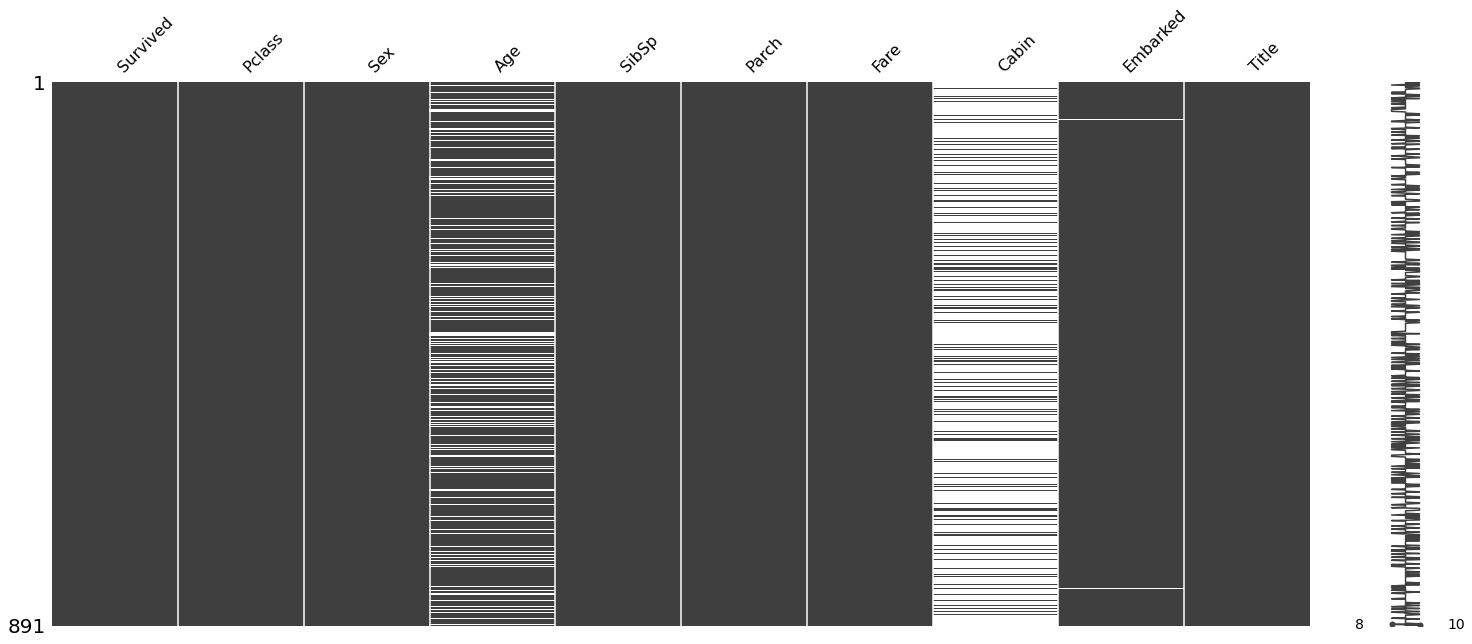

In [12]:
msno.matrix(df);

The most frequent ways to handle missing values are deleting samples with them or filling them with mean/median. There are a lot of them in our data, so obviously we cannot remove them

Age:

In [13]:
df['Age'].median()

28.0

I don't wanna simply fill Age with median because in this way I would assign 28 years to kids and old men as well. So here I will use the previously created feature Title and fill gaps with the median for the title group. I.e. Mr with a null value will get the median age for 'Mr'.

In [14]:
df['Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: Title, dtype: int64

All titles after 'Rev' I will combine to 'Other' value

In [15]:
df['Title'][~df['Title'].isin(['Mr', 'Miss', 'Mrs', 'Master', 'Dr', 'Rev'])] = 'Other'

Calculate median age for each title group (We should check, because if we had some group with all null values the median would be also null)

In [16]:
median_ages = dict(df.groupby('Title')['Age'].median())
print(median_ages)

{'Dr': 46.5, 'Master': 3.5, 'Miss': 21.0, 'Mr': 30.0, 'Mrs': 35.0, 'Other': 42.5, 'Rev': 46.5}


And fill missing values for `Age`

In [17]:
mask = df['Age'].isna()
df.loc[mask, 'Age'] = df[mask]['Title'].map(median_ages)

The next feature is `Cabin`

In [18]:
len(df['Cabin'].unique())

148

We have 148 unique values and (891-204) null values. The feature is useless and we will drop it

In [19]:
df.drop('Cabin', axis=1, inplace=True)

And we have `Embarked` feature with 2 null values, so I will replace them by most frequent value

In [20]:
df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [21]:
df.loc[df['Embarked'].isna(), 'Embarked'] = 'S'

## Exploratory Data Analysis(EDA)

#### Correlation matrix

It is better to start with correlation matrix to see telations between features

**NOTE**: only numerical features are in the matrix because the program cannot so easily find correlations between for example strings.<br>
**Positive correlation**: increase in feature X leads to an increase to feature Y.<br>
**Negative correlation**: increase in feature X leads to a decrease to feature Y.<br>
**NOTE** If 2 features have a really big correlation, this usually means that the features represent two very similar concepts. In such cases, we can simply remove one feature to improve model performance. This problem is called `MultiColinearity`

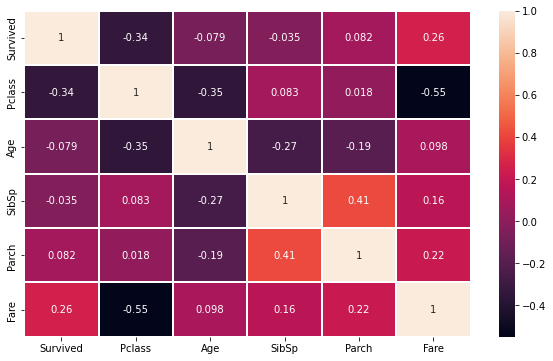

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(df.corr(), linewidths=0.1, annot=True);

Here we see that the highest correlation is between `Parch` and `SibSp`. The represent kinda similar things: number of parents and number of siblings, but the correlation is very low for MultiColinearity case (even thinking logically, the number of siblings doesn't depend on the number of parents and vise versa)

#### `Family` feature

But looking on those features closely I wanna combine them in one feature represents the number of family members

In [23]:
df['Family'] = df['SibSp'] + df['Parch']

After that remove them

In [24]:
df.drop(['SibSp', 'Parch'], axis=1, inplace=True)

#### `Survived` feature

Firstly let's look at our target (`Survived`) calss

In [25]:
surv_dist = df['Survived'].value_counts()
print(surv_dist)

0    549
1    342
Name: Survived, dtype: int64


And plot its distribution

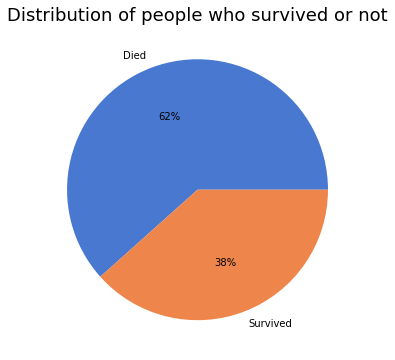

In [26]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(x=surv_dist.values, labels=['Died', 'Survived'], colors=palette, autopct='%.0f%%')
ax.set_title('Distribution of people who survived or not', fontsize=18);

We can conclude that significantly more people died than survived according to our data

#### `Sex` feature

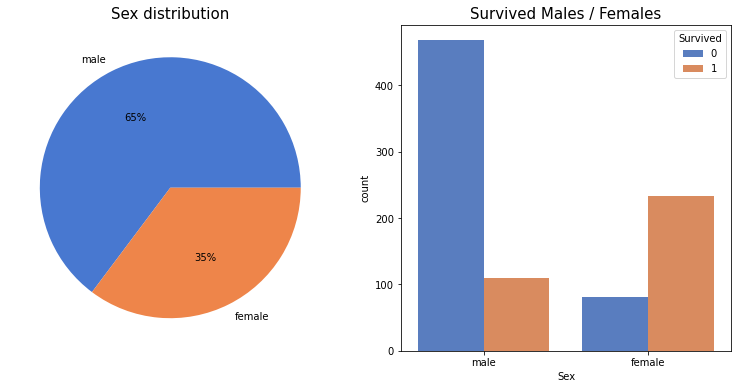

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(13, 6))

sex_dist = df['Sex'].value_counts()
ax[0].pie(x=sex_dist.values, labels=sex_dist.index, colors=palette, autopct='%.0f%%')
ax[0].set_title('Sex distribution', fontsize=15);

sns.countplot(x='Sex', hue='Survived', data=df, palette=palette, ax=ax[1])
ax[1].set_title('Survived Males / Females', fontsize=15);

- on Titanic there were almost twice bigger women than men. 
- twice bigger women survived as men
- about 3/4 of women survived, while not even 1/5 of men managed to do it

#### `Age` feature

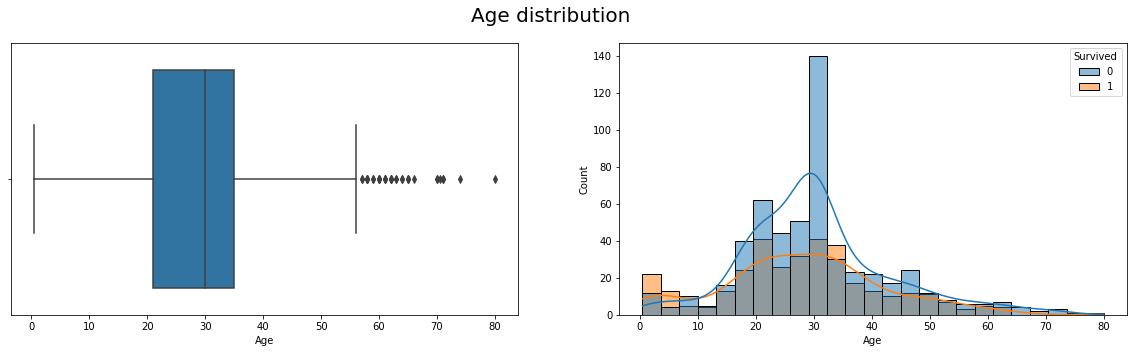

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

sns.boxplot(x='Age', data=df, ax=ax[0])

sns.histplot(x='Age', data=df, kde=True, hue='Survived', ax=ax[1], bins=25)

fig.suptitle('Age distribution', fontsize=20);

- the median age is about 30 years (28)
- the majority is from 20 to 35 years old, but there are kids close to 0 and old persons about 80
- most of the people from majority distribution died, while most of the kids and old persons survived

#### `Sex` and `Age` combined

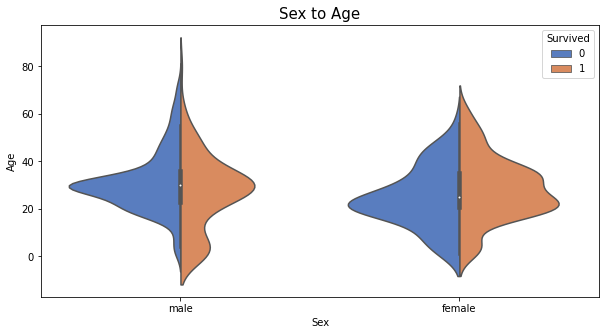

In [29]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.violinplot(x='Sex', y='Age', hue='Survived', split=True, palette=palette, data=df)
ax.set_title('Sex to Age', fontsize=15);

- strengthened previous conclusions
- for middle aged men chanses to survive are very low

#### `Pclass` feature

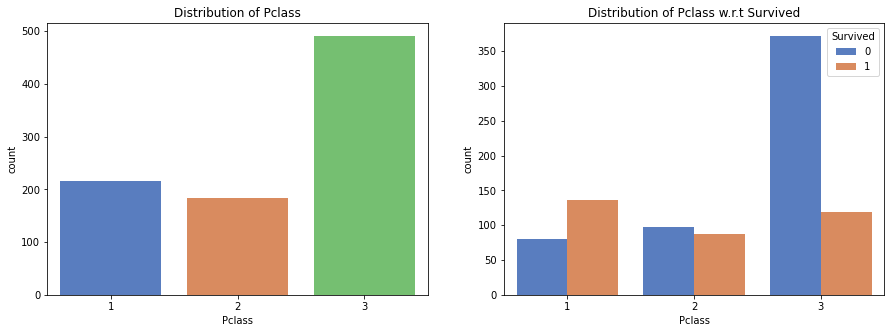

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(x='Pclass', data=df, palette=palette, ax=ax[0]).set(title='Distribution of Pclass');
sns.countplot(x='Pclass', data=df, hue='Survived', palette=palette, ax=ax[1]).set(title='Distribution of Pclass w.r.t Survived');

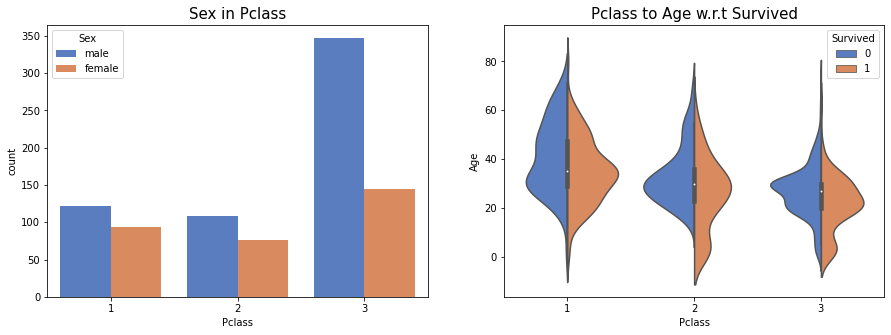

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(x='Pclass', hue='Sex', palette=palette, data=df, ax=ax[0])
ax[0].set_title('Sex in Pclass', fontsize=15);

sns.violinplot(x='Pclass', y='Age', hue='Survived', split=True, palette=palette, data=df, ax=ax[1])
ax[1].set_title('Pclass to Age w.r.t Survived', fontsize=15);

- 3rd class dominates, while 1st and 2nd almost same
- in 3rd class more than twice bigger men than women
- 1st class is "older" than 2nd, 2nd is "older" than 1st. Many children in 2nd and 3rd
- big chanses to survive among 1st class

#### `Embarked` feature

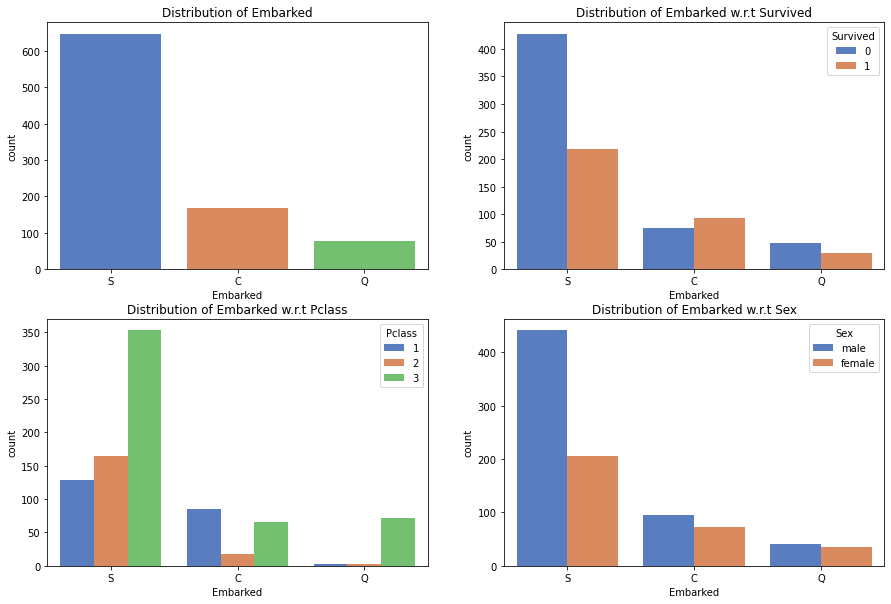

In [32]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.countplot(x='Embarked', data=df, palette=palette, ax=ax[0][0]).set(title='Distribution of Embarked');
sns.countplot(x='Embarked', data=df, hue='Survived', palette=palette, ax=ax[0][1]).set(title='Distribution of Embarked w.r.t Survived');
sns.countplot(x='Embarked', data=df, hue='Pclass', palette=palette, ax=ax[1][0]).set(title='Distribution of Embarked w.r.t Pclass');
sns.countplot(x='Embarked', data=df, hue='Sex', palette=palette, ax=ax[1][1]).set(title='Distribution of Embarked w.r.t Sex');

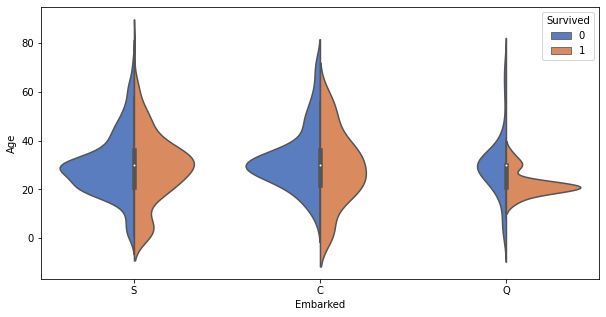

In [33]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.violinplot(x='Embarked', y='Age', hue='Survived', split=True, palette=palette, data=df, ax=ax);

- overwhelming majority embarked from S (Southampton)
- most of people embarked from C (Cherbourg) survived, opposite picture among people from S and Q (Queenstown)
- most of people from C were in 1st class (we already know that many from this class survived)
- 95% from Q were in 3rd class
- twice bigger men than women from S

#### `Fare` feature

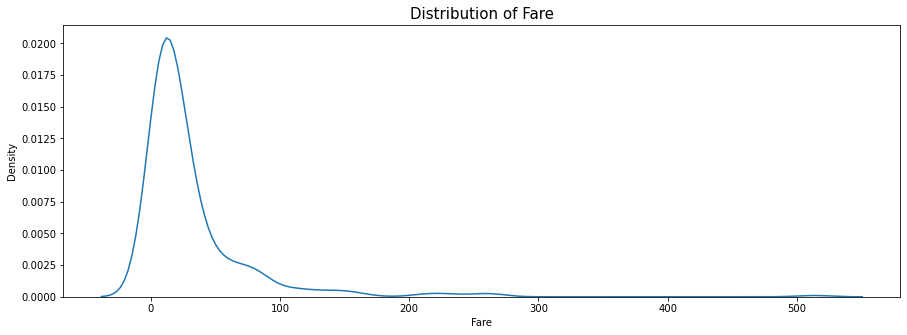

In [34]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.kdeplot(x='Fare', data=df, ax=ax)
ax.set_title('Distribution of Fare', fontsize=15);

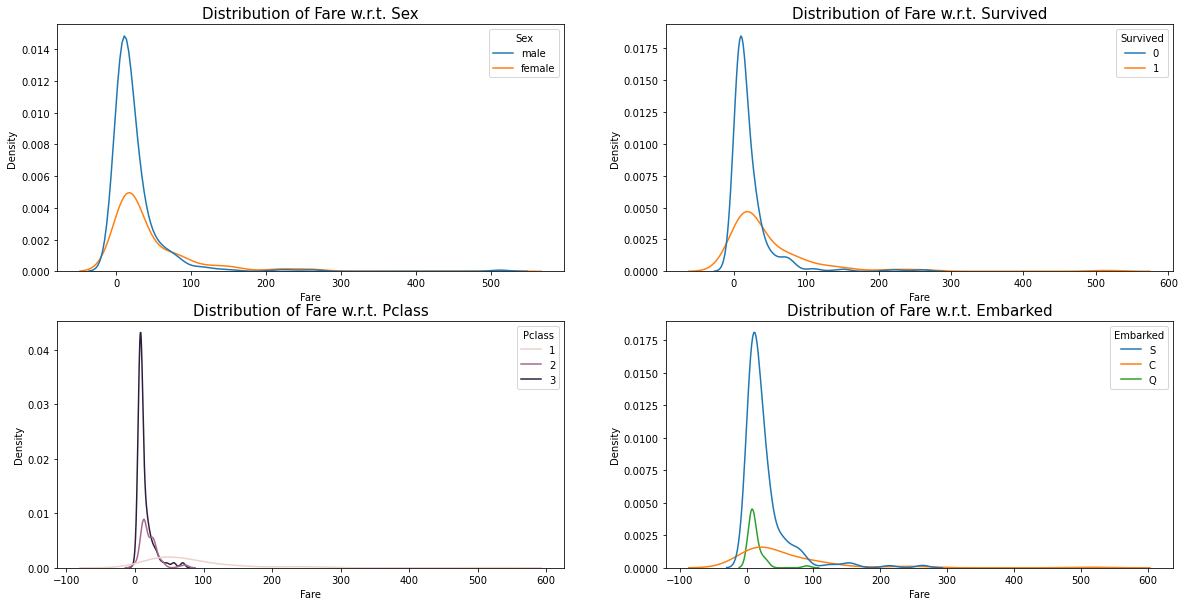

In [35]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

sns.kdeplot(x='Fare', hue='Sex', data=df, ax=ax[0][0])
ax[0][0].set_title('Distribution of Fare w.r.t. Sex', fontsize=15);

sns.kdeplot(x='Fare', hue='Survived', data=df, ax=ax[0][1])
ax[0][1].set_title('Distribution of Fare w.r.t. Survived', fontsize=15);

sns.kdeplot(x='Fare', hue='Pclass', data=df, ax=ax[1][0])
ax[1][0].set_title('Distribution of Fare w.r.t. Pclass', fontsize=15);

sns.kdeplot(x='Fare', hue='Embarked', data=df, ax=ax[1][1])
ax[1][1].set_title('Distribution of Fare w.r.t. Embarked', fontsize=15);

#### `Family` feature

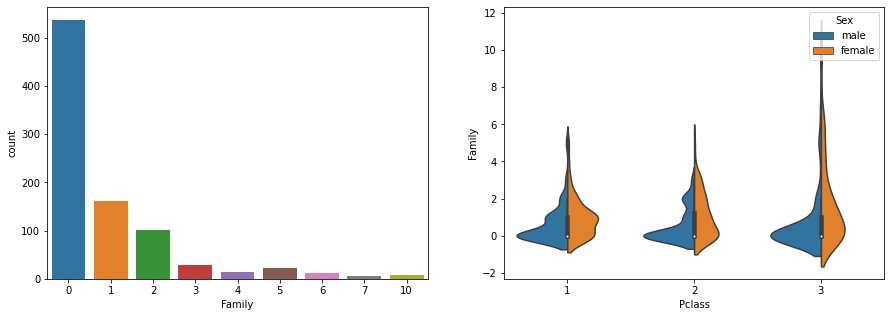

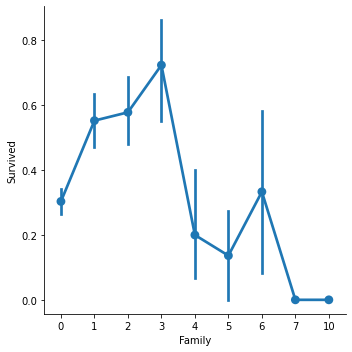

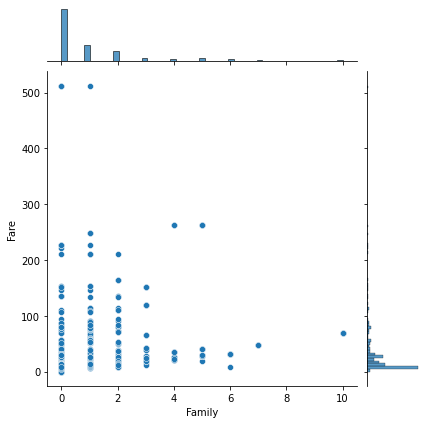

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(x='Family', data=df, ax=ax[0]);
sns.violinplot(x='Pclass', y='Family', hue='Sex', split=True, data=df, ax=ax[1]);

sns.catplot(x='Family', y='Survived', data=df, kind='point');
sns.jointplot(x='Family', y='Fare', data=df);

- a lot of alone people, count of people decreases with family members
- more alone men than women in groups
- all people with more than 6 family members were in 3rd class
- people with 1, 2, or 3 family members had significantly more chances to survive than others